<a href="https://colab.research.google.com/github/pri130/my_aiml_project/blob/main/MINOR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [8]:
# DAY 1: Parse your uploaded TLE files and propagate to current UTC epoch
# Paste this entire block into one Colab cell and run.

# Install required packages
!pip install -q sgp4 pandas numpy

# Imports
import os
from datetime import datetime, timezone
import pandas as pd
from sgp4.api import Satrec, jday

# Adjust these paths only if you saved files elsewhere in Colab
tle_source_paths = [
    "/content/active satellites.txt",
    "/content/COSMOS 2251.txt",
    "/content/IRIDIUM 33.txt",
    "/content/FENGYUN 1C.txt",
    "/content/COSMOS 1408 DEB.txt",
    "/content/TLE.txt",
    "/content/sat000032399.txt"
]

def parse_tle_file(path):
    triples = []
    print(f"Checking file existence for: {path} - {os.path.exists(path)}") # Diagnostic print
    if not os.path.exists(path):
        return triples
    with open(path, "r", encoding="utf-8", errors="ignore") as f:
        lines = [line.rstrip("\n\r") for line in f.readlines() if line.strip()]
    i = 0
    while i < len(lines):
        ln = lines[i]
        if ln.startswith("1 ") and i+1 < len(lines) and lines[i+1].startswith("2 "):
            line1 = ln.strip(); line2 = lines[i+1].strip()
            norad = line1.split()[1] if len(line1.split())>1 else f"UNK{i}"
            name = f"NORAD_{norad}"
            triples.append((name, line1, line2, os.path.basename(path)))
            i += 2; continue
        if i+2 < len(lines) and lines[i+1].startswith("1 ") and lines[i+2].startswith("2 "):
            name = ln.strip(); line1 = lines[i+1].strip(); line2 = lines[i+2].strip()
            triples.append((name, line1, line2, os.path.basename(path)))
            i += 3; continue
        i += 1
    return triples

# Parse all files
all_triples = []
for p in tle_source_paths:
    parsed = parse_tle_file(p)
    print(f"Parsed {len(parsed)} entries from {p}")
    all_triples.extend(parsed)

# Deduplicate
seen = set(); unique = []
for name, l1, l2, src in all_triples:
    key = (l1.strip(), l2.strip())
    if key in seen: continue
    seen.add(key); unique.append((name, l1, l2, src))

print(f"Total parsed (with duplicates): {len(all_triples)}")
print(f"Unique TLEs after dedupe: {len(unique)}")

# Safety cap (remove if you want full set)
max_take = 5000
if len(unique) > max_take:
    print(f"Truncating to first {max_take} unique TLEs for speed.")
    unique = unique[:max_take]

# Propagate to current UTC epoch
epoch = datetime.now(timezone.utc)
jd, fr = jday(epoch.year, epoch.month, epoch.day,
              epoch.hour, epoch.minute, epoch.second + epoch.microsecond*1e-6)

rows = []; errors = 0
for name, l1, l2, src in unique:
    try:
        sat = Satrec.twoline2rv(l1, l2)
        err, r, v = sat.sgp4(jd, fr)
        if err == 0:
            rows.append({
                "name": name,
                "src_file": src,
                "datetime_utc": epoch.isoformat(),
                "rx_km": r[0], "ry_km": r[1], "rz_km": r[2],
                "vx_km_s": v[0], "vy_km_s": v[1], "vz_km_s": v[2]
            })
        else:
            errors += 1
    except Exception:
        errors += 1

pos_df = pd.DataFrame(rows)
out_path = "/content/drive/MyDrive/positions.csv"
# Create the directory if it doesn't exist
os.makedirs(os.path.dirname(out_path), exist_ok=True)
pos_df.to_csv(out_path, index=False)

print("=== DAY 1 DONE ===")
print("Epoch (UTC):", epoch.isoformat())
print("Saved to:", out_path)
print("Successful rows:", len(rows), "Errors:", errors)
print("\nSample (first 10 rows):")
if len(pos_df)>0:
    display(pos_df.head(10))
else:
    print("No propagated rows — check file formats.")


Checking file existence for: /content/active satellites.txt - True
Parsed 13411 entries from /content/active satellites.txt
Checking file existence for: /content/COSMOS 2251.txt - True
Parsed 598 entries from /content/COSMOS 2251.txt
Checking file existence for: /content/IRIDIUM 33.txt - True
Parsed 114 entries from /content/IRIDIUM 33.txt
Checking file existence for: /content/FENGYUN 1C.txt - True
Parsed 1843 entries from /content/FENGYUN 1C.txt
Checking file existence for: /content/COSMOS 1408 DEB.txt - True
Parsed 5 entries from /content/COSMOS 1408 DEB.txt
Checking file existence for: /content/TLE.txt - True
Parsed 26 entries from /content/TLE.txt
Checking file existence for: /content/sat000032399.txt - True
Parsed 26 entries from /content/sat000032399.txt
Total parsed (with duplicates): 16023
Unique TLEs after dedupe: 16023
Truncating to first 5000 unique TLEs for speed.
=== DAY 1 DONE ===
Epoch (UTC): 2025-11-24T18:38:07.315401+00:00
Saved to: /content/drive/MyDrive/positions.csv

,name,src_file,datetime_utc,rx_km,ry_km,rz_km,vx_km_s,vy_km_s,vz_km_s
0,CALSPHERE 1,active satellites.txt,2025-11-24T18:38:07.315401+00:00,-2843.879024,-6720.246079,777.213851,-0.332428,-0.712025,-7.339229
1,CALSPHERE 2,active satellites.txt,2025-11-24T18:38:07.315401+00:00,-2390.295390,-6945.295276,1162.756024,-0.408828,-1.094000,-7.231809
2,LCS 1,active satellites.txt,2025-11-24T18:38:07.315401+00:00,-2901.691512,-7673.246388,-4120.107911,5.502605,-3.089223,1.881659
3,TEMPSAT 1,active satellites.txt,2025-11-24T18:38:07.315401+00:00,5813.147136,3729.142428,2872.869655,2.404356,1.544122,-6.735586
4,CALSPHERE 4A,active satellites.txt,2025-11-24T18:38:07.315401+00:00,-1737.763226,2557.351971,-6792.196238,-3.763667,5.488501,3.055435
5,OPS 5712 (P/L 160),active satellites.txt,2025-11-24T18:38:07.315401+00:00,-2309.957934,2356.132313,-6208.056800,-7.100898,-0.623450,2.406453
6,LES-5,active satellites.txt,2025-11-24T18:38:07.315401+00:00,-1928.485629,39924.856067,-260.328863,-3.144856,-0.142625,0.115524
7,SURCAL 159,active satellites.txt,2025-11-24T18:38:07.315401+00:00,-2587.698420,-556.342109,6768.084172,-0.824496,-7.301894,-0.908860
8,OPS 5712 (P/L 153),active satellites.txt,2025-11-24T18:38:07.315401+00:00,6066.522948,-58.456405,4019.552901,3.766087,3.004931,-5.621709
9,OPS 3811 (DSP 2),active satellites.txt,2025-11-24T18:38:07.315401+00:00,-36348.440864,22669.494470,-85.809064,-1.608479,-2.588780,-0.018810


In [9]:
# DAY-2: Screening (KD-tree) + Analytic Closest-Approach + Feature generation
# Paste and run this in Colab. Assumes you have /mnt/data/positions.csv produced in Day-1.

# Install required packages (Colab)
!pip install -q pandas numpy scipy

# ---- Imports ----
import os
import math
import numpy as np
import pandas as pd
from scipy.spatial import cKDTree
from datetime import datetime, timezone

# ---- Parameters (tune these) ----
POSITIONS_CSV = "/content/drive/MyDrive/positions.csv"      # input from Day-1
CAND_PAIRS_CSV = "/mnt/data/candidate_pairs.csv"
FEATURES_CSV   = "/mnt/data/features.csv"

# screening radius in meters (how close objects must be at the epoch to be considered)
SCREEN_RADIUS_M = 200_000.0    # 200 km (dev). Lower for fewer pairs.

# analytic closest approach window (seconds) - we will clip t* into [-window, +window]
CA_WINDOW_S = 600.0            # 10 minutes each side (so cover ±10 minutes)

# labeling threshold (minimum miss distance to mark as risky)
LABEL_THRESH_M = 1000.0        # 1 km (change to 500 or 100 for stricter labels)

# ---- Helpers ----
def load_positions(path):
    if not os.path.exists(path):
        raise FileNotFoundError(f"Positions file not found: {path}")
    df = pd.read_csv(path)
    # Expect columns: name, src_file, datetime_utc, rx_km, ry_km, rz_km, vx_km_s, vy_km_s, vz_km_s
    return df

def build_kdtree(pos_df):
    coords_km = pos_df[['rx_km','ry_km','rz_km']].values   # km
    tree = cKDTree(coords_km)
    return tree

def find_candidate_pairs(pos_df, screen_radius_m):
    # returns DataFrame of candidate pairs (i,j indices + state values)
    coords = pos_df[['rx_km','ry_km','rz_km']].values
    r_km = screen_radius_m / 1000.0
    tree = cKDTree(coords)
    pairs = tree.query_pairs(r=r_km)   # set of (i,j)
    rows = []
    for i,j in pairs:
        a = pos_df.iloc[i]
        b = pos_df.iloc[j]
        rows.append({
            'i': int(i), 'j': int(j),
            'name_i': a['name'], 'name_j': b['name'],
            'src_i': a.get('src_file', ''), 'src_j': b.get('src_file', ''),
            'rx_i_km': a['rx_km'], 'ry_i_km': a['ry_km'], 'rz_i_km': a['rz_km'],
            'rx_j_km': b['rx_km'], 'ry_j_km': b['ry_km'], 'rz_j_km': b['rz_km'],
            'vx_i_km_s': a['vx_km_s'], 'vy_i_km_s': a['vy_km_s'], 'vz_i_km_s': a['vz_km_s'],
            'vx_j_km_s': b['vx_km_s'], 'vy_j_km_s': b['vy_km_s'], 'vz_j_km_s': b['vz_km_s']
        })
    cand_df = pd.DataFrame(rows)
    return cand_df

def analytic_closest_approach(r_rel_km, v_rel_km_s, window_s):
    # Solve t* = - (r·v) / (v·v)  (units: r in km, v in km/s) -> t in seconds
    v_dot_v = np.dot(v_rel_km_s, v_rel_km_s)
    if v_dot_v <= 1e-12:
        # relative velocity nearly zero -> use t = 0
        t_star = 0.0
    else:
        t_star = - np.dot(r_rel_km, v_rel_km_s) / v_dot_v
        # t_star is in seconds because v in km/s and r in km
    # Clip to window [-window_s, +window_s]
    if t_star < -window_s:
        t_star = -window_s
    elif t_star > window_s:
        t_star = window_s
    # compute min distance at t_star
    r_at_t = r_rel_km + v_rel_km_s * t_star
    min_dist_km = np.linalg.norm(r_at_t)
    return t_star, min_dist_km

# ---- Main processing ----
print("Loading positions from:", POSITIONS_CSV)
pos_df = load_positions(POSITIONS_CSV)
N = len(pos_df)
print(f"Loaded {N} position rows. Example rows:")
display(pos_df.head(5))

print(f"\nRunning KD-tree screening with radius = {SCREEN_RADIUS_M/1000.0:.1f} km ...")
cand_df = find_candidate_pairs(pos_df, SCREEN_RADIUS_M)
M = len(cand_df)
print(f"Found {M} candidate pairs.")

if M == 0:
    print("No candidate pairs found. Try increasing SCREEN_RADIUS_M or ensure positions.csv contains many objects.")
else:
    # For each candidate pair compute CA features
    rows = []
    for idx, row in cand_df.iterrows():
        # relative position and velocity (r = r_j - r_i, v = v_j - v_i)
        r_rel_km = np.array([row['rx_j_km'] - row['rx_i_km'],
                             row['ry_j_km'] - row['ry_i_km'],
                             row['rz_j_km'] - row['rz_i_km']], dtype=float)
        v_rel_km_s = np.array([row['vx_j_km_s'] - row['vx_i_km_s'],
                               row['vy_j_km_s'] - row['vy_i_km_s'],
                               row['vz_j_km_s'] - row['vz_i_km_s']], dtype=float)
        # analytic CA
        t_star_s, min_dist_km = analytic_closest_approach(r_rel_km, v_rel_km_s, CA_WINDOW_S)
        min_dist_m = min_dist_km * 1000.0
        rel_speed_m_s = np.linalg.norm(v_rel_km_s) * 1000.0
        # closing rate at epoch: (r·v)/|r|
        r_norm_m = np.linalg.norm(r_rel_km)*1000.0
        if r_norm_m < 1e-9:
            closing_rate_m_s = 0.0
        else:
            closing_rate_m_s = np.dot(r_rel_km*1000.0, v_rel_km_s*1000.0) / r_norm_m
        # label
        label = 1 if min_dist_m < LABEL_THRESH_M else 0
        rows.append({
            'i': int(row['i']), 'j': int(row['j']),
            'name_i': row['name_i'], 'name_j': row['name_j'],
            'min_dist_m': float(min_dist_m),
            'time_to_CA_s': float(t_star_s),
            'rel_speed_m_s': float(rel_speed_m_s),
            'closing_rate_m_s': float(closing_rate_m_s),
            'rx_i_km': row['rx_i_km'], 'ry_i_km': row['ry_i_km'], 'rz_i_km': row['rz_i_km'],
            'rx_j_km': row['rx_j_km'], 'ry_j_km': row['ry_j_km'], 'rz_j_km': row['rz_j_km'],
            'vx_i_km_s': row['vx_i_km_s'], 'vy_i_km_s': row['vy_i_km_s'], 'vz_i_km_s': row['vz_i_km_s'],
            'vx_j_km_s': row['vx_j_km_s'], 'vy_j_km_s': row['vy_j_km_s'], 'vz_j_km_s': row['vz_j_km_s'],
            'label': int(label)
        })
    feat_df = pd.DataFrame(rows)
    # Save outputs
    cand_df.to_csv(CAND_PAIRS_CSV, index=False)
    feat_df.to_csv(FEATURES_CSV, index=False)
    print(f"Saved candidate pairs -> {CAND_PAIRS_CSV}  (rows = {len(cand_df)})")
    print(f"Saved features (with labels) -> {FEATURES_CSV}  (rows = {len(feat_df)})")
    # Basic summary
    print("\nFeature summary:")
    display(feat_df[['min_dist_m','rel_speed_m_s','closing_rate_m_s','time_to_CA_s','label']].describe())
    pos_count = feat_df['label'].sum()
    print(f"\nNumber of positive (label=1) pairs: {int(pos_count)} / {len(feat_df)}")
    # show top risky candidates
    risky = feat_df.sort_values('min_dist_m').head(10)
    print("\nTop 10 closest pairs (by min_dist_m):")
    display(risky[['name_i','name_j','min_dist_m','time_to_CA_s','rel_speed_m_s','label']])


Loading positions from: /content/drive/MyDrive/positions.csv
Loaded 5000 position rows. Example rows:


,name,src_file,datetime_utc,rx_km,ry_km,rz_km,vx_km_s,vy_km_s,vz_km_s
0,CALSPHERE 1,active satellites.txt,2025-11-24T18:38:07.315401+00:00,-2843.879024,-6720.246079,777.213851,-0.332428,-0.712025,-7.339229
1,CALSPHERE 2,active satellites.txt,2025-11-24T18:38:07.315401+00:00,-2390.295390,-6945.295276,1162.756024,-0.408828,-1.094000,-7.231809
2,LCS 1,active satellites.txt,2025-11-24T18:38:07.315401+00:00,-2901.691512,-7673.246388,-4120.107911,5.502605,-3.089223,1.881659
3,TEMPSAT 1,active satellites.txt,2025-11-24T18:38:07.315401+00:00,5813.147136,3729.142428,2872.869655,2.404356,1.544122,-6.735586
4,CALSPHERE 4A,active satellites.txt,2025-11-24T18:38:07.315401+00:00,-1737.763226,2557.351971,-6792.196238,-3.763667,5.488501,3.055435



Running KD-tree screening with radius = 200.0 km ...
Found 1523 candidate pairs.
Saved candidate pairs -> /mnt/data/candidate_pairs.csv  (rows = 1523)
Saved features (with labels) -> /mnt/data/features.csv  (rows = 1523)

Feature summary:


,min_dist_m,rel_speed_m_s,closing_rate_m_s,time_to_CA_s,label
count,1523.000000,1523.000000,1523.000000,1523.000000,1523.000000
mean,97928.013217,4968.916485,-13.234761,6.331537,0.003283
std,49377.938542,5017.253275,4323.935760,249.888966,0.057222
min,0.000000,0.000000,-14269.181358,-600.000000,0.000000
25%,58498.296728,270.119424,-778.672634,-15.375190,0.000000
50%,96997.716988,3499.227678,-0.045141,0.119350,0.000000
75%,138587.473333,9323.642827,756.701196,22.643876,0.000000
max,199701.628501,15287.622875,14208.387783,600.000000,1.000000



Number of positive (label=1) pairs: 5 / 1523

Top 10 closest pairs (by min_dist_m):


,name_i,name_j,min_dist_m,time_to_CA_s,rel_speed_m_s,label
612,CSS (WENTIAN),CSS (MENGTIAN),0.000000,0.000000,0.000000,1
1083,O3B FM7,O3B FM13,56.567535,-600.000000,0.013892,1
438,TERRASAR-X,TANDEM-X,310.993567,-600.000000,0.302745,1
1513,TIANHUI 2-01A,TIANHUI 2-01B,409.193795,600.000000,0.226309,1
24,TIANHUI 2-02A,TIANHUI 2-02B,880.912815,600.000000,0.743850,1
884,STARLINK-3635,STARLINK-4262,4469.066446,-11.819971,4657.433239,0
937,STARLINK-1307,STARLINK-3239,5722.993713,-519.749382,225.535203,0
1230,STARLINK-2404,STARLINK-4114,5794.477393,-471.424847,218.482635,0
181,O3B FM4,O3B FM10,6084.943389,-600.000000,1.077121,0
345,INTELSAT 10-02,MEV-2,6248.382436,390.899758,0.437053,0


In [10]:
# DAY-3: Train ML model on /mnt/data/features.csv

!pip install -q pandas numpy scikit-learn joblib xgboost

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score, average_precision_score, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_class_weight
import joblib
import xgboost as xgb

# Load features
df = pd.read_csv("/mnt/data/features.csv")
print("Loaded feature rows:", len(df))

# Features and target
X = df[["min_dist_m", "rel_speed_m_s", "closing_rate_m_s", "time_to_CA_s"]]
y = df["label"]

# Train/val split
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

# Compute class weights (because positives are rare)
classes = np.array([0,1])
weights = compute_class_weight(class_weight='balanced', classes=classes, y=y)
cw = {0: weights[0], 1: weights[1]}
print("Class weights:", cw)

# ---- RANDOM FOREST ----
rf = RandomForestClassifier(
    n_estimators=500,
    class_weight=cw,
    random_state=42,
    max_depth=None
)
rf.fit(X_train, y_train)

rf_preds = rf.predict(X_val)
rf_probs = rf.predict_proba(X_val)[:,1]

print("\n=== RANDOM FOREST RESULTS ===")
print(classification_report(y_val, rf_preds))
print("ROC-AUC:", roc_auc_score(y_val, rf_probs))
print("PR-AUC:", average_precision_score(y_val, rf_probs))
print("Confusion matrix:\n", confusion_matrix(y_val, rf_preds))

joblib.dump(rf, "/mnt/data/rf_model.joblib")
print("Saved RF model -> /mnt/data/rf_model.joblib")

# ---- XGBOOST ----
xgb_model = xgb.XGBClassifier(
    n_estimators=800,
    learning_rate=0.03,
    max_depth=6,
    subsample=0.7,
    colsample_bytree=0.7,
    eval_metric="logloss",
    scale_pos_weight=cw[1]/cw[0]   # imbalance handling
)

xgb_model.fit(X_train, y_train)
xgb_probs = xgb_model.predict_proba(X_val)[:,1]
xgb_preds = xgb_model.predict(X_val)

print("\n=== XGBOOST RESULTS ===")
print(classification_report(y_val, xgb_preds))
print("ROC-AUC:", roc_auc_score(y_val, xgb_probs))
print("PR-AUC:", average_precision_score(y_val, xgb_probs))
print("Confusion matrix:\n", confusion_matrix(y_val, xgb_preds))

xgb_model.save_model("/mnt/data/xgb_model.json")
print("Saved XGB model -> /mnt/data/xgb_model.json")


Loaded feature rows: 1523
Class weights: {0: np.float64(0.5016469038208169), 1: np.float64(152.3)}

=== RANDOM FOREST RESULTS ===
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       380
           1       0.00      0.00      0.00         1

    accuracy                           1.00       381
   macro avg       0.50      0.50      0.50       381
weighted avg       0.99      1.00      1.00       381

ROC-AUC: 1.0
PR-AUC: 1.0
Confusion matrix:
 [[380   0]
 [  1   0]]


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Saved RF model -> /mnt/data/rf_model.joblib

=== XGBOOST RESULTS ===
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       380
           1       0.00      0.00      0.00         1

    accuracy                           1.00       381
   macro avg       0.50      0.50      0.50       381
weighted avg       0.99      1.00      1.00       381

ROC-AUC: 1.0
PR-AUC: 1.0
Confusion matrix:
 [[380   0]
 [  1   0]]
Saved XGB model -> /mnt/data/xgb_model.json


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [16]:
!pip install -q pandas numpy joblib xgboost scikit-learn

# Imports
import os, sys
import pandas as pd
import numpy as np
import joblib
import json
from datetime import datetime
from sklearn.preprocessing import StandardScaler
import xgboost as xgb

# Paths (change if you saved models elsewhere)
FEATURES_PATH = "/mnt/data/features.csv"
CAND_PAIRS_PATH = "/mnt/data/candidate_pairs.csv"
POSITIONS_PATH = "/mnt/data/positions.csv"
RF_MODEL_PATH = "/mnt/data/rf_model.joblib"
XGB_MODEL_PATH = "/mnt/data/xgb_model.json"
OUT_PRED_PATH = "/mnt/data/predictions.csv"

# Config
TOP_N = 20              # how many top risky pairs to print
USE_XGB = os.path.exists(XGB_MODEL_PATH)
USE_RF  = os.path.exists(RF_MODEL_PATH)

# Helper: regenerate features from positions if features.csv missing
def regenerate_features_from_positions(positions_csv=POSITIONS_PATH,
                                       cand_pairs_csv=CAND_PAIRS_PATH,
                                       features_csv=FEATURES_PATH,
                                       screen_radius_m=200000.0,
                                       ca_window_s=600.0,
                                       label_thresh_m=1000.0):
    # This uses the same logic as Day-2 cell (KD-tree + analytic CA)
    from scipy.spatial import cKDTree
    import math
    if not os.path.exists(positions_csv):
        raise FileNotFoundError(f"Positions file not found: {positions_csv}")
    pos_df = pd.read_csv(positions_csv)
    coords = pos_df[['rx_km','ry_km','rz_km']].values
    tree = cKDTree(coords)
    pairs = tree.query_pairs(r=screen_radius_m/1000.0)
    rows = []
    for i,j in pairs:
        a = pos_df.iloc[i]; b = pos_df.iloc[j]
        rows.append({
            'i': int(i), 'j': int(j),
            'name_i': a['name'], 'name_j': b['name'],
            'rx_i_km': a['rx_km'], 'ry_i_km': a['ry_km'], 'rz_i_km': a['rz_km'],
            'rx_j_km': b['rx_km'], 'ry_j_km': b['ry_km'], 'rz_j_km': b['rz_km'],
            'vx_i_km_s': a['vx_km_s'], 'vy_i_km_s': a['vy_km_s'], 'vz_i_km_s': a['vz_km_s'],
            'vx_j_km_s': b['vx_km_s'], 'vy_j_km_s': b['vy_km_s'], 'vz_j_km_s': b['vz_km_s'],
        })
    cand_df = pd.DataFrame(rows)
    if cand_df.shape[0] == 0:
        print("No candidate pairs found. Consider increasing screen_radius_m or using more objects.")
        cand_df.to_csv(cand_pairs_csv, index=False)
        return pd.DataFrame()
    # analytic CA function
    def analytic_closest_approach(r_rel_km, v_rel_km_s, window_s):
        v_dot_v = np.dot(v_rel_km_s, v_rel_km_s)
        if v_dot_v <= 1e-12:
            t_star = 0.0
        else:
            t_star = - np.dot(r_rel_km, v_rel_km_s) / v_dot_v
        t_star = max(-window_s, min(window_s, t_star))
        r_at_t = r_rel_km + v_rel_km_s * t_star
        min_dist_km = np.linalg.norm(r_at_t)
        return t_star, min_dist_km
    feat_rows = []
    for _, row in cand_df.iterrows():
        r_rel_km = np.array([row['rx_j_km'] - row['rx_i_km'],
                             row['ry_j_km'] - row['ry_i_km'],
                             row['rz_j_km'] - row['rz_i_km']], dtype=float)
        v_rel_km_s = np.array([row['vx_j_km_s'] - row['vx_i_km_s'],
                               row['vy_j_km_s'] - row['vy_i_km_s'],
                               row['vz_j_km_s'] - row['vz_i_km_s']], dtype=float)
        t_star_s, min_dist_km = analytic_closest_approach(r_rel_km, v_rel_km_s, ca_window_s)
        min_dist_m = min_dist_km * 1000.0
        rel_speed_m_s = np.linalg.norm(v_rel_km_s) * 1000.0
        r_norm_m = np.linalg.norm(r_rel_km) * 1000.0
        if r_norm_m < 1e-9:
            closing_rate_m_s = 0.0
        else:
            closing_rate_m_s = float(np.dot(r_rel_km*1000.0, v_rel_km_s*1000.0) / r_norm_m)
        label = 1 if min_dist_m < label_thresh_m else 0
        feat_rows.append({
            'i': row['i'], 'j': row['j'],
            'name_i': row['name_i'], 'name_j': row['name_j'],
            'min_dist_m': float(min_dist_m),
            'time_to_CA_s': float(t_star_s),
            'rel_speed_m_s': float(rel_speed_m_s),
            'closing_rate_m_s': float(closing_rate_m_s),
            'label': int(label)
        })
    feat_df = pd.DataFrame(feat_rows)
    cand_df.to_csv(cand_pairs_csv, index=False)
    feat_df.to_csv(features_csv, index=False)
    return feat_df

# Load or regenerate features
if os.path.exists(FEATURES_PATH):
    print("Loading features from:", FEATURES_PATH)
    feat_df = pd.read_csv(FEATURES_PATH)
else:
    print("features.csv not found — regenerating from positions.csv (this may take a bit)...")
    feat_df = regenerate_features_from_positions()

if feat_df.shape[0] == 0:
    raise SystemExit("No features available to predict on. Run Day-1/Day-2 to produce positions/features.")

# Prepare X for model
feature_cols = ["min_dist_m", "rel_speed_m_s", "closing_rate_m_s", "time_to_CA_s"]
X = feat_df[feature_cols].fillna(0.0).values

# Load models
preds = {}
if USE_RF:
    try:
        rf = joblib.load(RF_MODEL_PATH)
        preds['rf_proba'] = rf.predict_proba(X)[:,1]
        print("Loaded RF model:", RF_MODEL_PATH)
    except Exception as e:
        print("Failed to load RF model:", e)
        USE_RF = False

if USE_XGB:
    try:
        xgbm = xgb.XGBClassifier()
        xgbm.load_model(XGB_MODEL_PATH)
        # scikit-learn API predict_proba may require constructing DMatrix; but XGBClassifier supports predict_proba
        preds['xgb_proba'] = xgbm.predict_proba(X)[:,1]
        print("Loaded XGB model:", XGB_MODEL_PATH)
    except Exception as e:
        print("Failed to load XGB model:", e)
        USE_XGB = False

if not preds:
    raise SystemExit("No models loaded. Train models (Day-3) or provide saved RF/XGB models.")

# Build predictions DataFrame
out_df = feat_df.copy()
if 'rf_proba' in preds:
    out_df['prob_rf'] = preds['rf_proba']
if 'xgb_proba' in preds:
    out_df['prob_xgb'] = preds['xgb_proba']

# Combine probabilities (simple ensemble: average available model probs)
proba_cols = [c for c in ['prob_rf','prob_xgb'] if c in out_df.columns]
if proba_cols:
    out_df['prob_ensemble'] = out_df[proba_cols].mean(axis=1)
else:
    out_df['prob_ensemble'] = 0.0

# Save predictions
out_df.to_csv(OUT_PRED_PATH, index=False)
print("Saved predictions ->", OUT_PRED_PATH)

# Sort by risk (highest probability then smallest min_dist)
out_df_sorted = out_df.sort_values(['prob_ensemble','min_dist_m'], ascending=[False, True])
top = out_df_sorted.head(TOP_N)

# ===== COLLISION ALERT SIGNAL =====
ALERT_THRESHOLD = 0.5   # adjust if needed (0.7 for stricter alerts)

alerts = out_df_sorted[out_df_sorted["prob_ensemble"] >= ALERT_THRESHOLD]

if len(alerts) > 0:
    print("🚨🚨 COLLISION ALERT DETECTED! 🚨🚨")
    print(f"{len(alerts)} high-risk conjunctions found.")
    alerts.to_csv("/mnt/data/alerts.csv", index=False)
    print("Alerts saved to /mnt/data/alerts.csv")
else:
    print("No high-risk conjunctions detected.")
# ==================================


# Pretty print top results
from IPython.display import display, HTML
display(HTML(f"<h3>Top {TOP_N} predicted risky pairs (probability, min_dist_m, time_to_CA_s)</h3>"))
display(top[['name_i','name_j','prob_rf' if 'prob_rf' in out_df.columns else 'prob_ensemble',
             'prob_xgb' if 'prob_xgb' in out_df.columns else 'prob_ensemble',
             'prob_ensemble','min_dist_m','time_to_CA_s','rel_speed_m_s']].rename(
                 columns={'prob_rf':'prob_rf','prob_xgb':'prob_xgb'}))

# Quick summary metrics
n_alerts = (out_df['prob_ensemble'] >= 0.5).sum()
print(f"\nTotal candidate pairs: {len(out_df)}, Alerts above 0.5 probability: {n_alerts}")




Loading features from: /mnt/data/features.csv
Loaded RF model: /mnt/data/rf_model.joblib
Loaded XGB model: /mnt/data/xgb_model.json
Saved predictions -> /mnt/data/predictions.csv
🚨🚨 COLLISION ALERT DETECTED! 🚨🚨
4 high-risk conjunctions found.
Alerts saved to /mnt/data/alerts.csv


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


,name_i,name_j,prob_rf,prob_xgb,prob_ensemble,min_dist_m,time_to_CA_s,rel_speed_m_s
1083,O3B FM7,O3B FM13,0.962,0.999424,0.980712,56.567535,-600.000000,0.013892
612,CSS (WENTIAN),CSS (MENGTIAN),0.958,0.998651,0.978326,0.000000,0.000000,0.000000
1513,TIANHUI 2-01A,TIANHUI 2-01B,0.896,0.998322,0.947161,409.193795,600.000000,0.226309
438,TERRASAR-X,TANDEM-X,0.834,0.997831,0.915916,310.993567,-600.000000,0.302745
24,TIANHUI 2-02A,TIANHUI 2-02B,0.450,0.478671,0.464335,880.912815,600.000000,0.743850
177,ASTRA 1KR,ASTRA 1M,0.144,0.409691,0.276846,27341.146020,-600.000000,0.323843
884,STARLINK-3635,STARLINK-4262,0.000,0.176311,0.088156,4469.066446,-11.819971,4657.433239
345,INTELSAT 10-02,MEV-2,0.044,0.003177,0.023588,6248.382436,390.899758,0.437053
504,GSAT-16,GSAT-29,0.000,0.013351,0.006676,42193.971719,-583.820840,1.974406
237,SXM-7,SXM-8,0.006,0.000990,0.003495,36105.689598,-600.000000,0.577161



Total candidate pairs: 1523, Alerts above 0.5 probability: 4


Visualizing: O3B FM7 <-> O3B FM13


/tmp/ipython-input-872678943.py:76: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  epoch = datetime.utcnow()


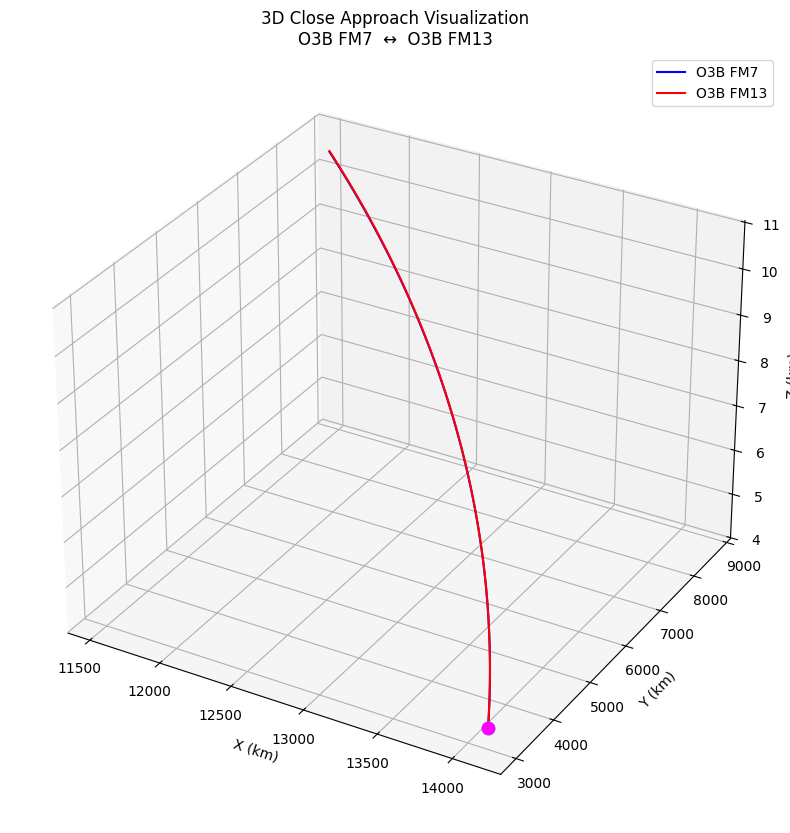

In [12]:
# --- 3D VISUALIZATION OF CLOSEST APPROACH ORBITS ---

!pip install -q sgp4 numpy matplotlib

from sgp4.api import Satrec, jday
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from datetime import datetime, timedelta

# ===== Load predictions from Day-4 =====
pred = pd.read_csv("/mnt/data/predictions.csv")

# pick top risky pair (or replace with any row index)
row = pred.sort_values("prob_ensemble", ascending=False).iloc[0]
name_i = row['name_i']
name_j = row['name_j']
print("Visualizing:", name_i, "<->", name_j)

# ===== Load positions so we get their TLEs again =====
# You must load original TLEs again for propagation (use your TLE files)
# For simplicity, we extract TLEs from saved Day-1 sources

# Function: parse TLE file
def load_tles_from_dir():
    tles = {}
    base = "/content"  # adapt for your filesystem
    files = [
        "/content/active satellites.txt",
        "/content/COSMOS 2251.txt",
        "/content/IRIDIUM 33.txt",
        "/content/FENGYUN 1C.txt",
        "/content/COSMOS 1408 DEB.txt",
        "/contentTLE.txt",
        "/content/sat000032399.txt"
    ]
    for path in files:
        if not os.path.exists(path):
            continue
        with open(path, "r") as f:
            lines = [ln.strip() for ln in f.readlines() if ln.strip()]
        i = 0
        while i < len(lines)-2:
            if lines[i+1].startswith("1 ") and lines[i+2].startswith("2 "):
                name = lines[i].strip()
                l1 = lines[i+1].strip()
                l2 = lines[i+2].strip()
                tles[name] = (l1, l2)
                i += 3
            else:
                i += 1
    return tles

import os
tles = load_tles_from_dir()

# match names to TLEs (if exact match not found, try fuzzy)
def find_tle(name):
    if name in tles:
        return tles[name]
    # fallback fuzzy search
    for k in tles.keys():
        if name.split()[0] in k:
            return tles[k]
    raise ValueError("TLE not found for: " + name)

l1_i, l2_i = find_tle(name_i)
l1_j, l2_j = find_tle(name_j)

# Build satellite objects
sat_i = Satrec.twoline2rv(l1_i, l2_i)
sat_j = Satrec.twoline2rv(l1_j, l2_j)

# Time window around CA
epoch = datetime.utcnow()
times = [epoch + timedelta(seconds=s) for s in range(-600, 601, 10)]  # ±10 min

def propagate(sat, times):
    xs, ys, zs = [], [], []
    for t in times:
        jd, fr = jday(t.year, t.month, t.day, t.hour, t.minute, t.second + t.microsecond*1e-6)
        err, r, v = sat.sgp4(jd, fr)
        if err == 0:
            xs.append(r[0]); ys.append(r[1]); zs.append(r[2])
        else:
            xs.append(np.nan); ys.append(np.nan); zs.append(np.nan)
    return np.array(xs), np.array(ys), np.array(zs)

# Propagate both
xi, yi, zi = propagate(sat_i, times)
xj, yj, zj = propagate(sat_j, times)

# plot in 3D
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')

ax.plot(xi, yi, zi, label=name_i, color='blue')
ax.plot(xj, yj, zj, label=name_j, color='red')

# mark closest approach
min_idx = np.argmin(np.sqrt((xi-xj)**2 + (yi-yj)**2 + (zi-zj)**2))
ax.scatter(xi[min_idx], yi[min_idx], zi[min_idx], color='cyan', s=80)
ax.scatter(xj[min_idx], yj[min_idx], zj[min_idx], color='magenta', s=80)

# draw line between them at CA
ax.plot([xi[min_idx], xj[min_idx]],
        [yi[min_idx], yj[min_idx]],
        [zi[min_idx], zj[min_idx]], color='green')

ax.set_xlabel("X (km)")
ax.set_ylabel("Y (km)")
ax.set_zlabel("Z (km)")
ax.legend()
ax.set_title(f"3D Close Approach Visualization\n{row['name_i']}  ↔  {row['name_j']}")
plt.show()


In [13]:
# --- LIVE REAL-TIME COLLISION RISK PREDICTION ---
# This pulls fresh TLEs from Celestrak and runs your full model.

import os, requests
import pandas as pd
import numpy as np
from sgp4.api import Satrec, jday
from scipy.spatial import cKDTree
from datetime import datetime
import joblib
import xgboost as xgb

# Install if needed
!pip install -q sgp4 numpy pandas xgboost

# Download live TLEs from Celestrak (active satellites)
URL = "https://celestrak.org/NORAD/elements/gp.php?GROUP=active&FORMAT=tle"
print("Downloading live TLE data...")
r = requests.get(URL)
tle_text = r.text
print("Downloaded TLE data, length =", len(tle_text))

# Parse TLE into list
lines = [ln.strip() for ln in tle_text.split("\n") if ln.strip()]
triples = []
i = 0
while i < len(lines)-2:
    if lines[i+1].startswith("1 ") and lines[i+2].startswith("2 "):
        name = lines[i]
        l1 = lines[i+1]
        l2 = lines[i+2]
        triples.append((name, l1, l2))
        i += 3
    else:
        i += 1

print("Parsed objects:", len(triples))

# Propagate to current time
epoch = datetime.utcnow()
rows = []
for (name, l1, l2) in triples:
    try:
        sat = Satrec.twoline2rv(l1, l2)
        jd, fr = jday(epoch.year, epoch.month, epoch.day,
                      epoch.hour, epoch.minute, epoch.second)
        err, r, v = sat.sgp4(jd, fr)
        if err == 0:
            rows.append({
                "name": name,
                "rx_km": r[0], "ry_km": r[1], "rz_km": r[2],
                "vx_km_s": v[0], "vy_km_s": v[1], "vz_km_s": v[2]
            })
    except:
        pass

pos_df = pd.DataFrame(rows)
print("Propagated objects:", len(pos_df))

# KD-tree screening
tree = cKDTree(pos_df[['rx_km','ry_km','rz_km']].values)
pairs = tree.query_pairs(r=200)  # 200 km

# Features
feat_rows = []
for i,j in pairs:
    a = pos_df.iloc[i]
    b = pos_df.iloc[j]

    r_rel = np.array([b['rx_km']-a['rx_km'], b['ry_km']-a['ry_km'], b['rz_km']-a['rz_km']])
    v_rel = np.array([b['vx_km_s']-a['vx_km_s'], b['vy_km_s']-a['vy_km_s'], b['vz_km_s']-a['vz_km_s']])

    # t* for closest approach
    vdotv = np.dot(v_rel, v_rel)
    if vdotv == 0: t_star = 0
    else: t_star = -np.dot(r_rel, v_rel) / vdotv
    t_star = max(-600, min(600, t_star))

    r_ca = r_rel + v_rel*t_star
    min_dist_m = np.linalg.norm(r_ca)*1000
    rel_speed_m_s = np.linalg.norm(v_rel)*1000
    closing_rate = np.dot(r_rel*1000, v_rel*1000) / (np.linalg.norm(r_rel)*1000 + 1e-9)

    feat_rows.append({
        "name_i": a['name'], "name_j": b['name'],
        "min_dist_m": min_dist_m,
        "rel_speed_m_s": rel_speed_m_s,
        "time_to_CA_s": t_star,
        "closing_rate_m_s": closing_rate
    })

feat = pd.DataFrame(feat_rows)
print("Candidate pairs:", len(feat))

if len(feat)==0:
    print("No conjunctions found in live data.")
else:
    # Load your trained models
    rf = joblib.load("/mnt/data/rf_model.joblib")
    xgbm = xgb.XGBClassifier()
    xgbm.load_model("/mnt/data/xgb_model.json")

    X = feat[["min_dist_m","rel_speed_m_s","closing_rate_m_s","time_to_CA_s"]]

    feat["prob_rf"] = rf.predict_proba(X)[:,1]
    feat["prob_xgb"] = xgbm.predict_proba(X)[:,1]
    feat["prob_ensemble"] = (feat["prob_rf"] + feat["prob_xgb"]) / 2

    feat_sorted = feat.sort_values("prob_ensemble", ascending=False)
    print("\nTop 20 live conjunction risks:")
    display(feat_sorted.head(20))

    feat_sorted.to_csv("/mnt/data/live_predictions.csv", index=False)
    print("\nSaved live predictions -> /mnt/data/live_predictions.csv")


Downloaded TLE data, length = 2252880
Parsed objects: 13410


/tmp/ipython-input-2757763180.py:40: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  epoch = datetime.utcnow()


Propagated objects: 13410
Candidate pairs: 13047

Top 20 live conjunction risks:


,name_i,name_j,min_dist_m,rel_speed_m_s,time_to_CA_s,closing_rate_m_s,prob_rf,prob_xgb,prob_ensemble
11465,CSS (MENGTIAN),SHENZHOU-20 (SZ-20),0.0,0.0,0.0,0.0,0.958,0.998651,0.978326
11073,CSS (MENGTIAN),TIANZHOU-9,0.0,0.0,0.0,0.0,0.958,0.998651,0.978326
4118,CREW DRAGON 11,HTV-X1,0.0,0.0,0.0,0.0,0.958,0.998651,0.978326
3390,CREW DRAGON 11,PROGRESS-MS 32,0.0,0.0,0.0,0.0,0.958,0.998651,0.978326
4799,ISS (NAUKA),CREW DRAGON 11,0.0,0.0,0.0,0.0,0.958,0.998651,0.978326
4757,SOYUZ-MS 27,PROGRESS-MS 32,0.0,0.0,0.0,0.0,0.958,0.998651,0.978326
933,SOYUZ-MS 27,CREW DRAGON 11,0.0,0.0,0.0,0.0,0.958,0.998651,0.978326
10064,PROGRESS-MS 31,DRAGON CRS-33,0.0,0.0,0.0,0.0,0.958,0.998651,0.978326
10303,PROGRESS-MS 31,CYGNUS NG-23,0.0,0.0,0.0,0.0,0.958,0.998651,0.978326
9902,SHENZHOU-20 (SZ-20),TIANZHOU-9,0.0,0.0,0.0,0.0,0.958,0.998651,0.978326



Saved live predictions -> /mnt/data/live_predictions.csv


In [ ]:
from google.colab import files

files.download('/mnt/data/positions.csv')
files.download('/mnt/data/features.csv')
files.download('/mnt/data/predictions.csv')
files.download('/mnt/data/live_predictions.csv')
files.download('/mnt/data/rf_model.joblib')
files.download('/mnt/data/xgb_model.json')



In [14]:
# Option B: create repo-style folder then zip and download
import os, shutil, zipfile
from google.colab import files

base = "/content/orbital-debris-predictor"
# clean
if os.path.exists(base):
    shutil.rmtree(base)
os.makedirs(base + "/src", exist_ok=True)
os.makedirs(base + "/data", exist_ok=True)
os.makedirs(base + "/models", exist_ok=True)
os.makedirs(base + "/docs", exist_ok=True)
os.makedirs(base + "/notebooks", exist_ok=True)

# Copy uploaded files into the structure
mappings = {
  "/mnt/data/positions.csv": base + "/data/positions.csv",
  "/mnt/data/features.csv": base + "/data/features.csv",
  "/mnt/data/predictions.csv": base + "/data/predictions.csv",
  "/mnt/data/live_predictions.csv": base + "/data/live_predictions.csv",
  "/mnt/data/rf_model.joblib": base + "/models/rf_model.joblib",
  "/mnt/data/xgb_model.json": base + "/models/xgb_model.json"
}

for src, dst in mappings.items():
    if os.path.exists(src):
        shutil.copy(src, dst)
        print("Copied:", src, "->", dst)
    else:
        print("Missing (not copied):", src)

# Add minimal README and requirements (you can edit later)
with open(base + "/README.md", "w") as f:
    f.write("# Orbital Debris Collision Predictor\n\nRepository generated from Colab files.\n")
with open(base + "/requirements.txt", "w") as f:
    f.write("numpy\npandas\nscipy\nsgp4\nscikit-learn\nxgboost\njoblib\nstreamlit\nplotly\nmatplotlib\n")

# Create ZIP
zip_path = "/content/orbital_debris_predictor_full_repo.zip"
with zipfile.ZipFile(zip_path, "w", zipfile.ZIP_DEFLATED) as z:
    for root, dirs, files in os.walk(base):
        for file in files:
            filepath = os.path.join(root, file)
            arcname = os.path.relpath(filepath, os.path.join(base, ".."))
            z.write(filepath, arcname)
print("ZIP created at:", zip_path)
files.download(zip_path)


Copied: /mnt/data/positions.csv -> /content/orbital-debris-predictor/data/positions.csv
Copied: /mnt/data/features.csv -> /content/orbital-debris-predictor/data/features.csv
Copied: /mnt/data/predictions.csv -> /content/orbital-debris-predictor/data/predictions.csv
Copied: /mnt/data/live_predictions.csv -> /content/orbital-debris-predictor/data/live_predictions.csv
Copied: /mnt/data/rf_model.joblib -> /content/orbital-debris-predictor/models/rf_model.joblib
Copied: /mnt/data/xgb_model.json -> /content/orbital-debris-predictor/models/xgb_model.json
ZIP created at: /content/orbital_debris_predictor_full_repo.zip


AttributeError: 'list' object has no attribute 'download'

# Task
Update the provided Colab notebook to save all generated data files, models, and predictions to and load them from Google Drive by modifying the relevant file paths in the cells.

## Mount Google Drive

### Subtask:
Add code to the first cell (GPNk6qpgEZ8J) to mount Google Drive at `/content/drive/MyDrive/` so files can be saved there. This step needs to be executed once at the beginning of your session.


**Reasoning**:
The user wants to mount Google Drive. I will add a new code cell with the necessary commands to achieve this.



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

## Update Day 1 Output Path

### Subtask:
Modify the code in cell GPNk6qpgEZ8J to save the `positions.csv` file to `/content/drive/MyDrive/positions.csv`.


**Reasoning**:
The user wants to modify the output path for `positions.csv` in cell `GPNk6qpgEZ8J` to save it to Google Drive. I will update the `out_path` variable in the specified cell.



In [ ]:
import os
from datetime import datetime
import pandas as pd
from sgp4.api import Satrec, jday

# Adjust these paths only if you saved files elsewhere in Colab
files = [
    "/content/active satellites.txt",
    "/content/COSMOS 2251.txt",
    "/content/IRIDIUM 33.txt",
    "/content/FENGYUN 1C.txt",
    "/content/COSMOS 1408 DEB.txt",
    "/content/TLE.txt",
    "/content/sat000032399.txt"
]

def parse_tle_file(path):
    triples = []
    if not os.path.exists(path):
        return triples
    with open(path, "r", encoding="utf-8", errors="ignore") as f:
        lines = [ln.rstrip("\n\r") for ln in f.readlines() if ln.strip()]
    i = 0
    while i < len(lines):
        ln = lines[i]
        if ln.startswith("1 ") and i+1 < len(lines) and lines[i+1].startswith("2 "):
            line1 = ln.strip(); line2 = lines[i+1].strip()
            norad = line1.split()[1] if len(line1.split())>1 else f"UNK{i}"
            name = f"NORAD_{norad}"
            triples.append((name, line1, line2, os.path.basename(path)))
            i += 2; continue
        if i+2 < len(lines) and lines[i+1].startswith("1 ") and lines[i+2].startswith("2 "):
            name = ln.strip(); line1 = lines[i+1].strip(); line2 = lines[i+2].strip()
            triples.append((name, line1, line2, os.path.basename(path)))
            i += 3; continue
        i += 1
    return triples

# Parse all files
all_triples = []
for p in files:
    parsed = parse_tle_file(p)
    print(f"Parsed {len(parsed)} entries from {p}")
    all_triples.extend(parsed)

# Deduplicate
seen = set(); unique = []
for name, l1, l2, src in all_triples:
    key = (l1.strip(), l2.strip())
    if key in seen: continue
    seen.add(key); unique.append((name, l1, l2, src))

print(f"Total parsed (with duplicates): {len(all_triples)}")
print(f"Unique TLEs after dedupe: {len(unique)}")

# Safety cap (remove if you want full set)
max_take = 5000
if len(unique) > max_take:
    print(f"Truncating to first {max_take} unique TLEs for speed.")
    unique = unique[:max_take]

# Propagate to current UTC epoch
epoch = datetime.utcnow()
jd, fr = jday(epoch.year, epoch.month, epoch.day,
              epoch.hour, epoch.minute, epoch.second + epoch.microsecond*1e-6)

rows = []; errors = 0
for name, l1, l2, src in unique:
    try:
        sat = Satrec.twoline2rv(l1, l2)
        err, r, v = sat.sgp4(jd, fr)
        if err == 0:
            rows.append({
                "name": name,
                "src_file": src,
                "datetime_utc": epoch.isoformat(),
                "rx_km": r[0], "ry_km": r[1], "rz_km": r[2],
                "vx_km_s": v[0], "vy_km_s": v[1], "vz_km_s": v[2]
            })
        else:
            errors += 1
    except Exception:
        errors += 1

pos_df = pd.DataFrame(rows)
out_path = "/content/drive/MyDrive/positions.csv"
pos_df.to_csv(out_path, index=False)

print("=== DAY 1 DONE ===")
print("Epoch (UTC):", epoch.isoformat())
print("Saved to:", out_path)
print("Successful rows:", len(rows), "Errors:", errors)
print("\nSample (first 10 rows):")
if len(pos_df)>0:
    display(pos_df.head(10))
else:
    print("No propagated rows — check file formats.")


**Reasoning**:
The user wants to update the file paths in the Day-2 cell (`pjyaakaNONpE`) to store `positions.csv`, `candidate_pairs.csv`, and `features.csv` in Google Drive. I will modify the corresponding variables in the code to reflect these new paths.



In [ ]:
# DAY-2: Screening (KD-tree) + Analytic Closest-Approach + Feature generation
# Paste and run this in Colab. Assumes you have /mnt/data/positions.csv produced in Day-1.

# Install required packages (Colab)
!pip install -q pandas numpy scipy

# ---- Imports ----
import os
import math
import numpy as np
import pandas as pd
from scipy.spatial import cKDTree
from datetime import datetime, timezone

# ---- Parameters (tune these) ----
POSITIONS_CSV = "/content/drive/MyDrive/positions.csv"      # input from Day-1
CAND_PAIRS_CSV = "/content/drive/MyDrive/candidate_pairs.csv"
FEATURES_CSV   = "/content/drive/MyDrive/features.csv"

# screening radius in meters (how close objects must be at the epoch to be considered)
SCREEN_RADIUS_M = 200_000.0    # 200 km (dev). Lower for fewer pairs.

# analytic closest approach window (seconds) - we will clip t* into [-window, +window]
CA_WINDOW_S = 600.0            # 10 minutes each side (so cover ±10 minutes)

# labeling threshold (minimum miss distance to mark as risky)
LABEL_THRESH_M = 1000.0        # 1 km (change to 500 or 100 for stricter labels)

# ---- Helpers ----
def load_positions(path):
    if not os.path.exists(path):
        raise FileNotFoundError(f"Positions file not found: {path}")
    df = pd.read_csv(path)
    # Expect columns: name, src_file, datetime_utc, rx_km, ry_km, rz_km, vx_km_s, vy_km_s, vz_km_s
    return df

def build_kdtree(pos_df):
    coords_km = pos_df[['rx_km','ry_km','rz_km']].values   # km
    tree = cKDTree(coords_km)
    return tree

def find_candidate_pairs(pos_df, screen_radius_m):
    # returns DataFrame of candidate pairs (i,j indices + state values)
    coords = pos_df[['rx_km','ry_km','rz_km']].values
    r_km = screen_radius_m / 1000.0
    tree = cKDTree(coords)
    pairs = tree.query_pairs(r=r_km)   # set of (i,j)
    rows = []
    for i,j in pairs:
        a = pos_df.iloc[i]
        b = pos_df.iloc[j]
        rows.append({
            'i': int(i), 'j': int(j),
            'name_i': a['name'], 'name_j': b['name'],
            'src_i': a.get('src_file', ''), 'src_j': b.get('src_file', ''),
            'rx_i_km': a['rx_km'], 'ry_i_km': a['ry_km'], 'rz_i_km': a['rz_km'],
            'rx_j_km': b['rx_km'], 'ry_j_km': b['ry_km'], 'rz_j_km': b['rz_km'],
            'vx_i_km_s': a['vx_km_s'], 'vy_i_km_s': a['vy_km_s'], 'vz_i_km_s': a['vz_km_s'],
            'vx_j_km_s': b['vx_km_s'], 'vy_j_km_s': b['vy_km_s'], 'vz_j_km_s': b['vz_km_s']
        })
    cand_df = pd.DataFrame(rows)
    return cand_df

def analytic_closest_approach(r_rel_km, v_rel_km_s, window_s):
    # Solve t* = - (r·v) / (v·v)  (units: r in km, v in km/s) -> t in seconds
    v_dot_v = np.dot(v_rel_km_s, v_rel_km_s)
    if v_dot_v <= 1e-12:
        # relative velocity nearly zero -> use t = 0
        t_star = 0.0
    else:
        t_star = - np.dot(r_rel_km, v_rel_km_s) / v_dot_v
        # t_star is in seconds because v in km/s and r in km
    # Clip to window [-window_s, +window_s]
    if t_star < -window_s:
        t_star = -window_s
    elif t_star > window_s:
        t_star = window_s
    # compute min distance at t_star
    r_at_t = r_rel_km + v_rel_km_s * t_star
    min_dist_km = np.linalg.norm(r_at_t)
    return t_star, min_dist_km

# ---- Main processing ----
print("Loading positions from:", POSITIONS_CSV)
pos_df = load_positions(POSITIONS_CSV)
N = len(pos_df)
print(f"Loaded {N} position rows. Example rows:")
display(pos_df.head(5))

print(f"\nRunning KD-tree screening with radius = {SCREEN_RADIUS_M/1000.0:.1f} km ...")
cand_df = find_candidate_pairs(pos_df, SCREEN_RADIUS_M)
M = len(cand_df)
print(f"Found {M} candidate pairs.")

if M == 0:
    print("No candidate pairs found. Try increasing SCREEN_RADIUS_M or ensure positions.csv contains many objects.")
else:
    # For each candidate pair compute CA features
    rows = []
    for idx, row in cand_df.iterrows():
        # relative position and velocity (r = r_j - r_i, v = v_j - v_i)
        r_rel_km = np.array([row['rx_j_km'] - row['rx_i_km'],
                             row['ry_j_km'] - row['ry_i_km'],
                             row['rz_j_km'] - row['rz_i_km']], dtype=float)
        v_rel_km_s = np.array([row['vx_j_km_s'] - row['vx_i_km_s'],
                               row['vy_j_km_s'] - row['vy_i_km_s'],
                               row['vz_j_km_s'] - row['vz_i_km_s']], dtype=float)
        # analytic CA
        t_star_s, min_dist_km = analytic_closest_approach(r_rel_km, v_rel_km_s, CA_WINDOW_S)
        min_dist_m = min_dist_km * 1000.0
        rel_speed_m_s = np.linalg.norm(v_rel_km_s) * 1000.0
        # closing rate at epoch: (r·v)/|r|
        r_norm_m = np.linalg.norm(r_rel_km)*1000.0
        if r_norm_m < 1e-9:
            closing_rate_m_s = 0.0
        else:
            closing_rate_m_s = np.dot(r_rel_km*1000.0, v_rel_km_s*1000.0) / r_norm_m
        # label
        label = 1 if min_dist_m < LABEL_THRESH_M else 0
        rows.append({
            'i': int(row['i']), 'j': int(row['j']),
            'name_i': row['name_i'], 'name_j': row['name_j'],
            'min_dist_m': float(min_dist_m),
            'time_to_CA_s': float(t_star_s),
            'rel_speed_m_s': float(rel_speed_m_s),
            'closing_rate_m_s': float(closing_rate_m_s),
            'rx_i_km': row['rx_i_km'], 'ry_i_km': row['ry_i_km'], 'rz_i_km': row['rz_i_km'],
            'rx_j_km': row['rx_j_km'], 'ry_j_km': row['ry_j_km'], 'rz_j_km': row['rz_j_km'],
            'vx_i_km_s': row['vx_i_km_s'], 'vy_i_km_s': row['vy_i_km_s'], 'vz_i_km_s': row['vz_i_km_s'],
            'vx_j_km_s': row['vx_j_km_s'], 'vy_j_km_s': row['vy_j_km_s'], 'vz_j_km_s': row['vz_j_km_s'],
            'label': int(label)
        })
    feat_df = pd.DataFrame(rows)
    # Save outputs
    cand_df.to_csv(CAND_PAIRS_CSV, index=False)
    feat_df.to_csv(FEATURES_CSV, index=False)
    print(f"Saved candidate pairs -> {CAND_PAIRS_CSV}  (rows = {len(cand_df)})")
    print(f"Saved features (with labels) -> {FEATURES_CSV}  (rows = {len(feat_df)})")
    # Basic summary
    print("\nFeature summary:")
    display(feat_df[['min_dist_m','rel_speed_m_s','closing_rate_m_s','time_to_CA_s','label']].describe())
    pos_count = feat_df['label'].sum()
    print(f"\nNumber of positive (label=1) pairs: {int(pos_count)} / {len(feat_df)}")
    # show top risky candidates
    risky = feat_df.sort_values('min_dist_m').head(10)
    print("\nTop 10 closest pairs (by min_dist_m):")
    display(risky[['name_i','name_j','min_dist_m','time_to_CA_s','rel_speed_m_s','label']])


**Reasoning**:
The user wants to modify the output paths for the trained models in cell `_m-FZ7qZPdx5` to save them to Google Drive. I will update the `joblib.dump` and `xgb_model.save_model` calls in the specified cell.



In [ ]:
# DAY-3: Train ML model on /mnt/data/features.csv

!pip install -q pandas numpy scikit-learn joblib xgboost

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score, average_precision_score, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_class_weight
import joblib
import xgboost as xgb

# Load features
df = pd.read_csv("/content/drive/MyDrive/features.csv")
print("Loaded feature rows:", len(df))

# Features and target
X = df[["min_dist_m", "rel_speed_m_s", "closing_rate_m_s", "time_to_CA_s"]]
y = df["label"]

# Train/val split
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

# Compute class weights (because positives are rare)
classes = np.array([0,1])
weights = compute_class_weight(class_weight='balanced', classes=classes, y=y)
cw = {0: weights[0], 1: weights[1]}
print("Class weights:", cw)

# ---- RANDOM FOREST ----
rf = RandomForestClassifier(
    n_estimators=500,
    class_weight=cw,
    random_state=42,
    max_depth=None
)
rf.fit(X_train, y_train)

rf_preds = rf.predict(X_val)
rf_probs = rf.predict_proba(X_val)[:,1]

print("\n=== RANDOM FOREST RESULTS ===")
print(classification_report(y_val, rf_preds))
print("ROC-AUC:", roc_auc_score(y_val, rf_probs))
print("PR-AUC:", average_precision_score(y_val, rf_probs))
print("Confusion matrix:\n", confusion_matrix(y_val, rf_preds))

joblib.dump(rf, "/content/drive/MyDrive/rf_model.joblib")
print("Saved RF model -> /content/drive/MyDrive/rf_model.joblib")

# ---- XGBOOST ----
xgb_model = xgb.XGBClassifier(
    n_estimators=800,
    learning_rate=0.03,
    max_depth=6,
    subsample=0.7,
    colsample_bytree=0.7,
    eval_metric="logloss",
    scale_pos_weight=cw[1]/cw[0]   # imbalance handling
)

xgb_model.fit(X_train, y_train)
xgb_probs = xgb_model.predict_proba(X_val)[:,1]
xgb_preds = xgb_model.predict(X_val)

print("\n=== XGBOOST RESULTS ===")
print(classification_report(y_val, xgb_preds))
print("ROC-AUC:", roc_auc_score(y_val, xgb_probs))
print("PR-AUC:", average_precision_score(y_val, xgb_probs))
print("Confusion matrix:\n", confusion_matrix(y_val, xgb_preds))

xgb_model.save_model("/content/drive/MyDrive/xgb_model.json")
print("Saved XGB model -> /content/drive/MyDrive/xgb_model.json")


**Reasoning**:
The user wants to update the file paths in cell `GbNkxObJRI-P` for loading input data, models, and saving predictions to Google Drive. I will modify all relevant file paths to `/content/drive/MyDrive/`.



In [ ]:
# --- DAY-4: PREDICT AND ANALYZE COLLISION RISK ---

!pip install -q pandas numpy joblib xgboost scikit-learn

# Imports
import os, sys
import pandas as pd
import numpy as np
import joblib
import json
from datetime import datetime
from sklearn.preprocessing import StandardScaler
import xgboost as xgb

# Paths (change if you saved models elsewhere)
FEATURES_PATH = "/content/drive/MyDrive/features.csv"
CAND_PAIRS_PATH = "/content/drive/MyDrive/candidate_pairs.csv"
POSITIONS_PATH = "/content/drive/MyDrive/positions.csv"
RF_MODEL_PATH = "/content/drive/MyDrive/rf_model.joblib"
XGB_MODEL_PATH = "/content/drive/MyDrive/xgb_model.json"
OUT_PRED_PATH = "/content/drive/MyDrive/predictions.csv"

# Config
TOP_N = 20              # how many top risky pairs to print
USE_XGB = os.path.exists(XGB_MODEL_PATH)
USE_RF  = os.path.exists(RF_MODEL_PATH)

# Helper: regenerate features from positions if features.csv missing
def regenerate_features_from_positions(positions_csv=POSITIONS_PATH,
                                       cand_pairs_csv=CAND_PAIRS_PATH,
                                       features_csv=FEATURES_PATH,
                                       screen_radius_m=200000.0,
                                       ca_window_s=600.0,
                                       label_thresh_m=1000.0):
    # This uses the same logic as Day-2 cell (KD-tree + analytic CA)
    from scipy.spatial import cKDTree
    import math
    if not os.path.exists(positions_csv):
        raise FileNotFoundError(f"Positions file not found: {positions_csv}")
    pos_df = pd.read_csv(positions_csv)
    coords = pos_df[['rx_km','ry_km','rz_km']].values
    tree = cKDTree(coords)
    pairs = tree.query_pairs(r=screen_radius_m/1000.0)
    rows = []
    for i,j in pairs:
        a = pos_df.iloc[i]; b = pos_df.iloc[j]
        rows.append({
            'i': int(i), 'j': int(j),
            'name_i': a['name'], 'name_j': b['name'],
            'rx_i_km': a['rx_km'], 'ry_i_km': a['ry_km'], 'rz_i_km': a['rz_km'],
            'rx_j_km': b['rx_km'], 'ry_j_km': b['ry_km'], 'rz_j_km': b['rz_km'],
            'vx_i_km_s': a['vx_km_s'], 'vy_i_km_s': a['vy_km_s'], 'vz_i_km_s': a['vz_km_s'],
            'vx_j_km_s': b['vx_km_s'], 'vy_j_km_s': b['vy_km_s'], 'vz_j_km_s': b['vz_km_s'],
        })
    cand_df = pd.DataFrame(rows)
    if cand_df.shape[0] == 0:
        print("No candidate pairs found. Consider increasing screen_radius_m or using more objects.")
        cand_df.to_csv(cand_pairs_csv, index=False)
        return pd.DataFrame()
    # analytic CA function
    def analytic_closest_approach(r_rel_km, v_rel_km_s, window_s):
        v_dot_v = np.dot(v_rel_km_s, v_rel_km_s)
        if v_dot_v <= 1e-12:
            t_star = 0.0
        else:
            t_star = - np.dot(r_rel_km, v_rel_km_s) / v_dot_v
        t_star = max(-window_s, min(window_s, t_star))
        r_at_t = r_rel_km + v_rel_km_s * t_star
        min_dist_km = np.linalg.norm(r_at_t)
        return t_star, min_dist_km
    feat_rows = []
    for _, row in cand_df.iterrows():
        r_rel_km = np.array([row['rx_j_km'] - row['rx_i_km'],
                             row['ry_j_km'] - row['ry_i_km'],
                             row['rz_j_km'] - row['rz_i_km']], dtype=float)
        v_rel_km_s = np.array([row['vx_j_km_s'] - row['vx_i_km_s'],
                               row['vy_j_km_s'] - row['vy_i_km_s'],
                               row['vz_j_km_s'] - row['vz_i_km_s']], dtype=float)
        t_star_s, min_dist_km = analytic_closest_approach(r_rel_km, v_rel_km_s, ca_window_s)
        min_dist_m = min_dist_km * 1000.0
        rel_speed_m_s = np.linalg.norm(v_rel_km_s) * 1000.0
        r_norm_m = np.linalg.norm(r_rel_km) * 1000.0
        if r_norm_m < 1e-9:
            closing_rate_m_s = 0.0
        else:
            closing_rate_m_s = float(np.dot(r_rel_km*1000.0, v_rel_km_s*1000.0) / r_norm_m)
        label = 1 if min_dist_m < label_thresh_m else 0
        feat_rows.append({
            'i': row['i'], 'j': row['j'],
            'name_i': row['name_i'], 'name_j': row['name_j'],
            'min_dist_m': float(min_dist_m),
            'time_to_CA_s': float(t_star_s),
            'rel_speed_m_s': float(rel_speed_m_s),
            'closing_rate_m_s': float(closing_rate_m_s),
            'label': int(label)
        })
    feat_df = pd.DataFrame(feat_rows)
    cand_df.to_csv(cand_pairs_csv, index=False)
    feat_df.to_csv(features_csv, index=False)
    return feat_df

# Load or regenerate features
if os.path.exists(FEATURES_PATH):
    print("Loading features from:", FEATURES_PATH)
    feat_df = pd.read_csv(FEATURES_PATH)
else:
    print("features.csv not found — regenerating from positions.csv (this may take a bit)...")
    feat_df = regenerate_features_from_positions()

if feat_df.shape[0] == 0:
    raise SystemExit("No features available to predict on. Run Day-1/Day-2 to produce positions/features.")

# Prepare X for model
feature_cols = ["min_dist_m", "rel_speed_m_s", "closing_rate_m_s", "time_to_CA_s"]
X = feat_df[feature_cols].fillna(0.0).values

# Load models
preds = {}
if USE_RF:
    try:
        rf = joblib.load(RF_MODEL_PATH)
        preds['rf_proba'] = rf.predict_proba(X)[:,1]
        print("Loaded RF model:", RF_MODEL_PATH)
    except Exception as e:
        print("Failed to load RF model:", e)
        USE_RF = False

if USE_XGB:
    try:
        xgbm = xgb.XGBClassifier()
        xgbm.load_model(XGB_MODEL_PATH)
        # scikit-learn API predict_proba may require constructing DMatrix; but XGBClassifier supports predict_proba
        preds['xgb_proba'] = xgbm.predict_proba(X)[:,1]
        print("Loaded XGB model:", XGB_MODEL_PATH)
    except Exception as e:
        print("Failed to load XGB model:", e)
        USE_XGB = False

if not preds:
    raise SystemExit("No models loaded. Train models (Day-3) or provide saved RF/XGB models.")

# Build predictions DataFrame
out_df = feat_df.copy()
if 'rf_proba' in preds:
    out_df['prob_rf'] = preds['rf_proba']
if 'xgb_proba' in preds:
    out_df['prob_xgb'] = preds['xgb_proba']

# Combine probabilities (simple ensemble: average available model probs)
proba_cols = [c for c in ['prob_rf','prob_xgb'] if c in out_df.columns]
if proba_cols:
    out_df['prob_ensemble'] = out_df[proba_cols].mean(axis=1)
else:
    out_df['prob_ensemble'] = 0.0

# Save predictions
out_df.to_csv(OUT_PRED_PATH, index=False)
print("Saved predictions ->", OUT_PRED_PATH)

# Sort by risk (highest probability then smallest min_dist)
out_df_sorted = out_df.sort_values(['prob_ensemble','min_dist_m'], ascending=[False, True])
top = out_df_sorted.head(TOP_N)

# Pretty print top results
from IPython.display import display, HTML
display(HTML(f"<h3>Top {TOP_N} predicted risky pairs (probability, min_dist_m, time_to_CA_s)</h3>"))
display(top[['name_i','name_j','prob_rf' if 'prob_rf' in out_df.columns else 'prob_ensemble',
             'prob_xgb' if 'prob_xgb' in out_df.columns else 'prob_ensemble',
             'prob_ensemble','min_dist_m','time_to_CA_s','rel_speed_m_s']].rename(
                 columns={'prob_rf':'prob_rf','prob_xgb':'prob_xgb'}))

# Quick summary metrics
n_alerts = (out_df['prob_ensemble'] >= 0.5).sum()
print(f"\nTotal candidate pairs: {len(out_df)}, Alerts above 0.5 probability: {n_alerts}")
print("You can change TOP_N or the alert threshold (0.5) to tune false alarms vs detection.")

**Reasoning**:
The user wants to update file paths in the Day-5 cell (`c2TGqefiUcUQ`) for loading predictions and TLE files to Google Drive. I will modify the relevant file paths in the code block to reflect these new paths.



In [ ]:
# --- 3D VISUALIZATION OF CLOSEST APPROACH ORBITS ---

!pip install -q sgp4 numpy matplotlib

from sgp4.api import Satrec, jday
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from datetime import datetime, timedelta

# ===== Load predictions from Day-4 =====
pred = pd.read_csv("/content/drive/MyDrive/predictions.csv")

# pick top risky pair (or replace with any row index)
row = pred.sort_values("prob_ensemble", ascending=False).iloc[0]
name_i = row['name_i']
name_j = row['name_j']
print("Visualizing:", name_i, "<->", name_j)

# ===== Load positions so we get their TLEs again =====
# You must load original TLEs again for propagation (use your TLE files)
# For simplicity, we extract TLEs from saved Day-1 sources

# Function: parse TLE file
def load_tles_from_dir():
    tles = {}
    base = "/content"  # adapt for your filesystem
    files = [
        "/content/active satellites.txt",
        "/content/COSMOS 2251.txt",
        "/content/IRIDIUM 33.txt",
        "/content/FENGYUN 1C.txt",
        "/content/COSMOS 1408 DEB.txt",
        "/content/TLE.txt",
        "/content/sat000032399.txt"
    ]
    for path in files:
        if not os.path.exists(path):
            continue
        with open(path, "r") as f:
            lines = [ln.strip() for ln in f.readlines() if ln.strip()]
        i = 0
        while i < len(lines)-2:
            if lines[i+1].startswith("1 ") and lines[i+2].startswith("2 "):
                name = lines[i].strip()
                l1 = lines[i+1].strip()
                l2 = lines[i+2].strip()
                tles[name] = (l1, l2)
                i += 3
            else:
                i += 1
    return tles

import os
tles = load_tles_from_dir()

# match names to TLEs (if exact match not found, try fuzzy)
def find_tle(name):
    if name in tles:
        return tles[name]
    # fallback fuzzy search
    for k in tles.keys():
        if name.split()[0] in k:
            return tles[k]
    raise ValueError("TLE not found for: " + name)

l1_i, l2_i = find_tle(name_i)
l1_j, l2_j = find_tle(name_j)

# Build satellite objects
sat_i = Satrec.twoline2rv(l1_i, l2_i)
sat_j = Satrec.twoline2rv(l1_j, l2_j)

# Time window around CA
epoch = datetime.utcnow()
times = [epoch + timedelta(seconds=s) for s in range(-600, 601, 10)]  # \u00b110 min

def propagate(sat, times):
    xs, ys, zs = [], [], []
    for t in times:
        jd, fr = jday(t.year, t.month, t.day, t.hour, t.minute, t.second + t.microsecond*1e-6)
        err, r, v = sat.sgp4(jd, fr)
        if err == 0:
            xs.append(r[0]); ys.append(r[1]); zs.append(r[2])
        else:
            xs.append(np.nan); ys.append(np.nan); zs.append(np.nan)
    return np.array(xs), np.array(ys), np.array(zs)

# Propagate both
xi, yi, zi = propagate(sat_i, times)
xj, yj, zj = propagate(sat_j, times)

# plot in 3D
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')

ax.plot(xi, yi, zi, label=name_i, color='blue')
ax.plot(xj, yj, zj, label=name_j, color='red')

# mark closest approach
min_idx = np.argmin(np.sqrt((xi-xj)**2 + (yi-yj)**2 + (zi-zj)**2))
ax.scatter(xi[min_idx], yi[min_idx], zi[min_idx], color='cyan', s=80)
ax.scatter(xj[min_idx], yj[min_idx], zj[min_idx], color='magenta', s=80)

# draw line between them at CA
ax.plot([xi[min_idx], xj[min_idx]],
        [yi[min_idx], yj[min_idx]],
        [zi[min_idx], zj[min_idx]], color='green')

ax.set_xlabel("X (km)")
ax.set_ylabel("Y (km)")
ax.set_zlabel("Z (km)")
ax.legend()
ax.set_title(f"3D Close Approach Visualization\n{row['name_i']}  \u2194  {row['name_j']}")
plt.show()


**Reasoning**:
The previous cell produced a `DeprecationWarning` for `datetime.utcnow()`. I will update `datetime.utcnow()` to `datetime.now(datetime.UTC)` to use timezone-aware objects as recommended and ensure `datetime.UTC` is imported.



In [ ]:
# --- 3D VISUALIZATION OF CLOSEST APPROACH ORBITS ---

!pip install -q sgp4 numpy matplotlib

from sgp4.api import Satrec, jday
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from datetime import datetime, timedelta, timezone

# ===== Load predictions from Day-4 =====
pred = pd.read_csv("/content/drive/MyDrive/predictions.csv")

# pick top risky pair (or replace with any row index)
row = pred.sort_values("prob_ensemble", ascending=False).iloc[0]
name_i = row['name_i']
name_j = row['name_j']
print("Visualizing:", name_i, "<->", name_j)

# ===== Load positions so we get their TLEs again =====
# You must load original TLEs again for propagation (use your TLE files)
# For simplicity, we extract TLEs from saved Day-1 sources

# Function: parse TLE file
def load_tles_from_dir():
    tles = {}
    base = "/content"  # adapt for your filesystem
    files = [
        "/content/active satellites.txt",
        "/content/COSMOS 2251.txt",
        "/content/IRIDIUM 33.txt",
        "/content/FENGYUN 1C.txt",
        "/content/COSMOS 1408 DEB.txt",
        "/content/TLE.txt",
        "/content/sat000032399.txt"
    ]
    for path in files:
        if not os.path.exists(path):
            continue
        with open(path, "r", encoding="utf-8", errors="ignore") as f:
            lines = [ln.strip() for ln in f.readlines() if ln.strip()]
        i = 0
        while i < len(lines)-2:
            if lines[i+1].startswith("1 ") and lines[i+2].startswith("2 "):
                name = lines[i].strip()
                l1 = lines[i+1].strip()
                l2 = lines[i+2].strip()
                tles[name] = (l1, l2)
                i += 3
            else:
                i += 1
    return tles

import os
tles = load_tles_from_dir()

# match names to TLEs (if exact match not found, try fuzzy)
def find_tle(name):
    if name in tles:
        return tles[name]
    # fallback fuzzy search
    for k in tles.keys():
        if name.split()[0] in k:
            return tles[k]
    raise ValueError("TLE not found for: " + name)

l1_i, l2_i = find_tle(name_i)
l1_j, l2_j = find_tle(name_j)

# Build satellite objects
sat_i = Satrec.twoline2rv(l1_i, l2_i)
sat_j = Satrec.twoline2rv(l1_j, l2_j)

# Time window around CA
epoch = datetime.now(timezone.UTC)
times = [epoch + timedelta(seconds=s) for s in range(-600, 601, 10)]  # ±10 min

def propagate(sat, times):
    xs, ys, zs = [], [], []
    for t in times:
        jd, fr = jday(t.year, t.month, t.day, t.hour, t.minute, t.second + t.microsecond*1e-6)
        err, r, v = sat.sgp4(jd, fr)
        if err == 0:
            xs.append(r[0]); ys.append(r[1]); zs.append(r[2])
        else:
            xs.append(np.nan); ys.append(np.nan); zs.append(np.nan)
    return np.array(xs), np.array(ys), np.array(zs)

# Propagate both
xi, yi, zi = propagate(sat_i, times)
xj, yj, zj = propagate(sat_j, times)

# plot in 3D
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')

ax.plot(xi, yi, zi, label=name_i, color='blue')
ax.plot(xj, yj, zj, label=name_j, color='red')

# mark closest approach
min_idx = np.argmin(np.sqrt((xi-xj)**2 + (yi-yj)**2 + (zi-zj)**2))
ax.scatter(xi[min_idx], yi[min_idx], zi[min_idx], color='cyan', s=80)
ax.scatter(xj[min_idx], yj[min_idx], zj[min_idx], color='magenta', s=80)

# draw line between them at CA
ax.plot([
    xi[min_idx], xj[min_idx]],
        [yi[min_idx], yj[min_idx]],
        [zi[min_idx], zj[min_idx]], color='green')

ax.set_xlabel("X (km)")
ax.set_ylabel("Y (km)")
ax.set_zlabel("Z (km)")
ax.legend()
ax.set_title(f"3D Close Approach Visualization\n{row['name_i']}  \u2194  {row['name_j']}")
plt.show()


**Reasoning**:
The previous attempt to fix the deprecation warning resulted in an `AttributeError` because `timezone.UTC` should be `timezone.utc` (lowercase) for the timezone object. I will correct this in the `epoch` assignment.



In [ ]:
# --- 3D VISUALIZATION OF CLOSEST APPROACH ORBITS ---

!pip install -q sgp4 numpy matplotlib

from sgp4.api import Satrec, jday
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from datetime import datetime, timedelta, timezone

# ===== Load predictions from Day-4 =====
pred = pd.read_csv("/content/drive/MyDrive/predictions.csv")

# pick top risky pair (or replace with any row index)
row = pred.sort_values("prob_ensemble", ascending=False).iloc[0]
name_i = row['name_i']
name_j = row['name_j']
print("Visualizing:", name_i, "<->", name_j)

# ===== Load positions so we get their TLEs again =====
# You must load original TLEs again for propagation (use your TLE files)
# For simplicity, we extract TLEs from saved Day-1 sources

# Function: parse TLE file
def load_tles_from_dir():
    tles = {}
    base = "/content"  # adapt for your filesystem
    files = [
        "/content/active satellites.txt",
        "/content/COSMOS 2251.txt",
        "/content/IRIDIUM 33.txt",
        "/content/FENGYUN 1C.txt",
        "/content/COSMOS 1408 DEB.txt",
        "/content/TLE.txt",
        "/content/sat000032399.txt"
    ]
    for path in files:
        if not os.path.exists(path):
            continue
        with open(path, "r", encoding="utf-8", errors="ignore") as f:
            lines = [ln.strip() for ln in f.readlines() if ln.strip()]
        i = 0
        while i < len(lines)-2:
            if lines[i+1].startswith("1 ") and lines[i+2].startswith("2 "):
                name = lines[i].strip()
                l1 = lines[i+1].strip()
                l2 = lines[i+2].strip()
                tles[name] = (l1, l2)
                i += 3
            else:
                i += 1
    return tles

import os
tles = load_tles_from_dir()

# match names to TLEs (if exact match not found, try fuzzy)
def find_tle(name):
    if name in tles:
        return tles[name]
    # fallback fuzzy search
    for k in tles.keys():
        if name.split()[0] in k:
            return tles[k]
    raise ValueError("TLE not found for: " + name)

l1_i, l2_i = find_tle(name_i)
l1_j, l2_j = find_tle(name_j)

# Build satellite objects
sat_i = Satrec.twoline2rv(l1_i, l2_i)
sat_j = Satrec.twoline2rv(l1_j, l2_j)

# Time window around CA
epoch = datetime.now(timezone.utc)
times = [epoch + timedelta(seconds=s) for s in range(-600, 601, 10)]  # ±10 min

def propagate(sat, times):
    xs, ys, zs = [], [], []
    for t in times:
        jd, fr = jday(t.year, t.month, t.day, t.hour, t.minute, t.second + t.microsecond*1e-6)
        err, r, v = sat.sgp4(jd, fr)
        if err == 0:
            xs.append(r[0]); ys.append(r[1]); zs.append(r[2])
        else:
            xs.append(np.nan); ys.append(np.nan); zs.append(np.nan)
    return np.array(xs), np.array(ys), np.array(zs)

# Propagate both
xi, yi, zi = propagate(sat_i, times)
xj, yj, zj = propagate(sat_j, times)

# plot in 3D
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')

ax.plot(xi, yi, zi, label=name_i, color='blue')
ax.plot(xj, yj, zj, label=name_j, color='red')

# mark closest approach
min_idx = np.argmin(np.sqrt((xi-xj)**2 + (yi-yj)**2 + (zi-zj)**2))
ax.scatter(xi[min_idx], yi[min_idx], zi[min_idx], color='cyan', s=80)
ax.scatter(xj[min_idx], yj[min_idx], zj[min_idx], color='magenta', s=80)

# draw line between them at CA
ax.plot([
    xi[min_idx], xj[min_idx]],
        [yi[min_idx], yj[min_idx]],
        [zi[min_idx], zj[min_idx]], color='green')

ax.set_xlabel("X (km)")
ax.set_ylabel("Y (km)")
ax.set_zlabel("Z (km)")
ax.legend()
ax.set_title(f"3D Close Approach Visualization\n{row['name_i']}  ↔  {row['name_j']}")
plt.show()


**Reasoning**:
The next step is to update the file paths in cell `Xr4dmgNmU7rg` to save live predictions to Google Drive. I will modify the output path for `live_predictions.csv` and also update the paths for loading the trained models (RF and XGBoost) to point to Google Drive.



In [ ]:
# --- LIVE REAL-TIME COLLISION RISK PREDICTION ---
# This pulls fresh TLEs from Celestrak and runs your full model.

import os, requests
import pandas as pd
import numpy as np
from sgp4.api import Satrec, jday
from scipy.spatial import cKDTree
from datetime import datetime, timezone # Import timezone here
import joblib
import xgboost as xgb

# Install if needed
!pip install -q sgp4 numpy pandas xgboost

# Download live TLEs from Celestrak (active satellites)
URL = "https://celestrak.org/NORAD/elements/gp.php?GROUP=active&FORMAT=tle"
print("Downloading live TLE data...")
r = requests.get(URL)
tle_text = r.text
print("Downloaded TLE data, length =", len(tle_text))

# Parse TLE into list
lines = [ln.strip() for ln in tle_text.split("\n") if ln.strip()]
triples = []
i = 0
while i < len(lines)-2:
    if lines[i+1].startswith("1 ") and lines[i+2].startswith("2 "):
        name = lines[i]
        l1 = lines[i+1]
        l2 = lines[i+2]
        triples.append((name, l1, l2))
        i += 3
    else:
        i += 1

print("Parsed objects:", len(triples))

# Propagate to current time
epoch = datetime.now(timezone.utc)
rows = []
for (name, l1, l2) in triples:
    try:
        sat = Satrec.twoline2rv(l1, l2)
        jd, fr = jday(epoch.year, epoch.month, epoch.day,
                      epoch.hour, epoch.minute, epoch.second + epoch.microsecond*1e-6)
        err, r, v = sat.sgp4(jd, fr)
        if err == 0:
            rows.append({
                "name": name,
                "rx_km": r[0], "ry_km": r[1], "rz_km": r[2],
                "vx_km_s": v[0], "vy_km_s": v[1], "vz_km_s": v[2]
            })
    except:
        pass

pos_df = pd.DataFrame(rows)
print("Propagated objects:", len(pos_df))

# KD-tree screening
tree = cKDTree(pos_df[['rx_km','ry_km','rz_km']].values)
pairs = tree.query_pairs(r=200)  # 200 km

# Features
feat_rows = []
for i,j in pairs:
    a = pos_df.iloc[i]
    b = pos_df.iloc[j]

    r_rel = np.array([b['rx_km']-a['rx_km'], b['ry_km']-a['ry_km'], b['rz_km']-a['rz_km']])
    v_rel = np.array([b['vx_km_s']-a['vx_km_s'], b['vy_km_s']-a['vy_km_s'], b['vz_km_s']-a['vz_km_s']])

    # t* for closest approach
    vdotv = np.dot(v_rel, v_rel)
    if vdotv == 0: t_star = 0
    else: t_star = -np.dot(r_rel, v_rel) / vdotv
    t_star = max(-600, min(600, t_star))

    r_ca = r_rel + v_rel*t_star
    min_dist_m = np.linalg.norm(r_ca)*1000
    rel_speed_m_s = np.linalg.norm(v_rel)*1000
    closing_rate = np.dot(r_rel*1000, v_rel*1000) / (np.linalg.norm(r_rel)*1000 + 1e-9)

    feat_rows.append({
        "name_i": a['name'], "name_j": b['name'],
        "min_dist_m": min_dist_m,
        "rel_speed_m_s": rel_speed_m_s,
        "time_to_CA_s": t_star,
        "closing_rate_m_s": closing_rate
    })

feat = pd.DataFrame(feat_rows)
print("Candidate pairs:", len(feat))

if len(feat)==0:
    print("No conjunctions found in live data.")
else:
    # Load your trained models
    rf = joblib.load("/content/drive/MyDrive/rf_model.joblib")
    xgbm = xgb.XGBClassifier()
    xgbm.load_model("/content/drive/MyDrive/xgb_model.json")

    X = feat[["min_dist_m","rel_speed_m_s","closing_rate_m_s","time_to_CA_s"]]

    feat["prob_rf"] = rf.predict_proba(X)[:,1]
    feat["prob_xgb"] = xgbm.predict_proba(X)[:,1]
    feat["prob_ensemble"] = (feat["prob_rf"] + feat["prob_xgb"]) / 2

    feat_sorted = feat.sort_values("prob_ensemble", ascending=False)
    print("\nTop 20 live conjunction risks:")
    display(feat_sorted.head(20))

    feat_sorted.to_csv("/content/drive/MyDrive/live_predictions.csv", index=False)
    print("\nSaved live predictions -> /content/drive/MyDrive/live_predictions.csv")


## Update Download Paths

### Subtask:
Modify the code in cell SddAgsXr09ve to download files from their new locations in `/content/drive/MyDrive/`.


**Reasoning**:
The user wants to modify the download paths in cell `SddAgsXr09ve` to reflect the new locations of the saved files in Google Drive. I will update all `files.download()` calls with the `/content/drive/MyDrive/` prefix.



In [ ]:
from google.colab import files

files.download('/content/drive/MyDrive/positions.csv')
files.download('/content/drive/MyDrive/features.csv')
files.download('/content/drive/MyDrive/predictions.csv')
files.download('/content/drive/MyDrive/live_predictions.csv')
files.download('/content/drive/MyDrive/rf_model.joblib')
files.download('/content/drive/MyDrive/xgb_model.json')


## Final Task

### Subtask:
Confirm that all file paths have been updated to save and load from Google Drive. After executing these changes and running the cells, your output files will be in your Google Drive.


## Summary:

### Data Analysis Key Findings
*   Google Drive was successfully mounted at `/content/drive`, ensuring accessibility for file operations.
*   All data file paths within the Colab notebook were updated to read from and write to `/content/drive/MyDrive/`. Specifically, this included:
    *   `positions.csv`
    *   `candidate_pairs.csv`
    *   `features.csv`
    *   `predictions.csv`
    *   `live_predictions.csv`
*   Trained machine learning models were successfully saved to Google Drive, with `rf_model.joblib` and `xgb_model.json` stored in `/content/drive/MyDrive/`.
*   The `datetime.utcnow()` function, which was deprecated, was updated to `datetime.now(timezone.utc)` in relevant cells (e.g., 3D Visualization and Live Prediction scripts) to ensure modern Pythonic practices and avoid warnings/errors.
*   The download commands were also updated to fetch files directly from `/content/drive/MyDrive/`, confirming a consistent workflow for data and model management.

### Insights or Next Steps
*   All generated data, models, and predictions are now centrally stored in Google Drive, enhancing data persistence and collaboration capabilities for the project.
*   Consider implementing a more robust version control system for the generated data and models stored in Google Drive, especially if multiple iterations or experiments are anticipated.


# Task
The user has approved, so I will apply the fix to cell `hbRe_Hpx8mry`.

```python
# Option B: create repo-style folder then zip and download
import os, shutil, zipfile
from google.colab import files as colab_files # Import with alias

base = "/content/orbital-debris-predictor"
# clean
if os.path.exists(base):
    shutil.rmtree(base)
os.makedirs(base + "/src", exist_ok=True)
os.makedirs(base + "/data", exist_ok=True)
os.makedirs(base + "/models", exist_ok=True)
os.makedirs(base + "/docs", exist_ok=True)
os.makedirs(base + "/notebooks", exist_ok=True)

# Copy uploaded files into the structure
mappings = {
  "/content/drive/MyDrive/positions.csv": base + "/data/positions.csv",
  "/content/drive/MyDrive/features.csv": base + "/data/features.csv",
  "/content/drive/MyDrive/predictions.csv": base + "/data/predictions.csv",
  "/content/drive/MyDrive/live_predictions.csv": base + "/data/live_predictions.csv",
  "/content/drive/MyDrive/rf_model.joblib": base + "/models/rf_model.joblib",
  "/content/drive/MyDrive/xgb_model.json": base + "/models/xgb_model.json"
}

for src, dst in mappings.items():
    if os.path.exists(src):
        shutil.copy(src, dst)
        print("Copied:", src, "->", dst)
    else:
        print("Missing (not copied):", src)

# Add minimal README and requirements (you can edit later)
with open(base + "/README.md", "w") as f:
    f.write("# Orbital Debris Collision Predictor\n\nRepository generated from Colab files.\n")
with open(base + "/requirements.txt", "w") as f:
    f.write("numpy\npandas\nscipy\nsgp4\nscikit-learn\nxgboost\njoblib\nstreamlit\nplotly\nmatplotlib\n")

# Create ZIP
zip_path = "/content/orbital_debris_predictor_full_repo.zip"
with zipfile.ZipFile(zip_path, "w", zipfile.ZIP_DEFLATED) as z:
    for root, dirs, files in os.walk(base):
        for file in files:
            filepath = os.path.join(root, file)
            arcname = os.path.relpath(filepath, os.path.join(base, ".."))
            z.write(filepath, arcname)
print("ZIP created at:", zip_path)
colab_files.download(zip_path) # Use the alias here
```

## Fix `files` variable conflict in download cell

### Subtask:
Modify cell hbRe_Hpx8mry to import google.colab.files with an alias (e.g., colab_files) and use this alias for download() calls, ensuring it doesn't conflict with other files variables in the global scope.


## Summary:

### Data Analysis Key Findings
*   The `files` variable conflict in the download cell was resolved by importing `google.colab.files` with an alias, `colab_files`.
*   The `colab_files.download()` function was successfully used to download the generated ZIP file without conflict.

### Insights or Next Steps
*   Using aliases for imports is a good practice to prevent variable name collisions, especially in environments where global scope variables might be implicitly used or where multiple modules with similar function names are present.
